<a href="https://www.kaggle.com/code/ashishpathak778/06-08-25-titanic?scriptVersionId=257325373" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanicpr/titanic_train.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif



In [3]:
df = pd.read_csv("/kaggle/input/titanicpr/titanic_train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.dropna(axis = 1,thresh= 0.7*len(df),inplace = True)
numerical_cols = df.select_dtypes(include = ['int64','float64']).columns
categorical_cols = df.select_dtypes(include = ['int64','float64']).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [6]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [7]:
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]

print(constant_features)


[]


In [8]:
# 4. Quasi-constant features 
quasi_constant_features = []
threshold = 0.95

for col in X_train.columns:
    freq = X_train[col].value_counts(normalize=True).values[0]
    if freq >= threshold:
        quasi_constant_features.append(col)

print("Quasi-constant features:", quasi_constant_features)

X_train.drop(columns=quasi_constant_features, inplace=True)
X_test.drop(columns=quasi_constant_features, inplace=True)


Quasi-constant features: []


In [9]:
duplicated_features = []
cols = X_train.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if X_train[cols[i]].equals(X_train[cols[j]]):
            duplicated_features.append(cols[j])
print(duplicated_features)

[]


In [10]:
numeric_X_train = X_train.select_dtypes(include=['number'])
corr_matrix = numeric_X_train.corr()
corr_threshold = 0.98
corr_pairs = set()

# Find highly correlated features
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            corr_pairs.add(corr_matrix.columns[i])

print("Highly Correlated Features:", corr_pairs)

Highly Correlated Features: set()


[]

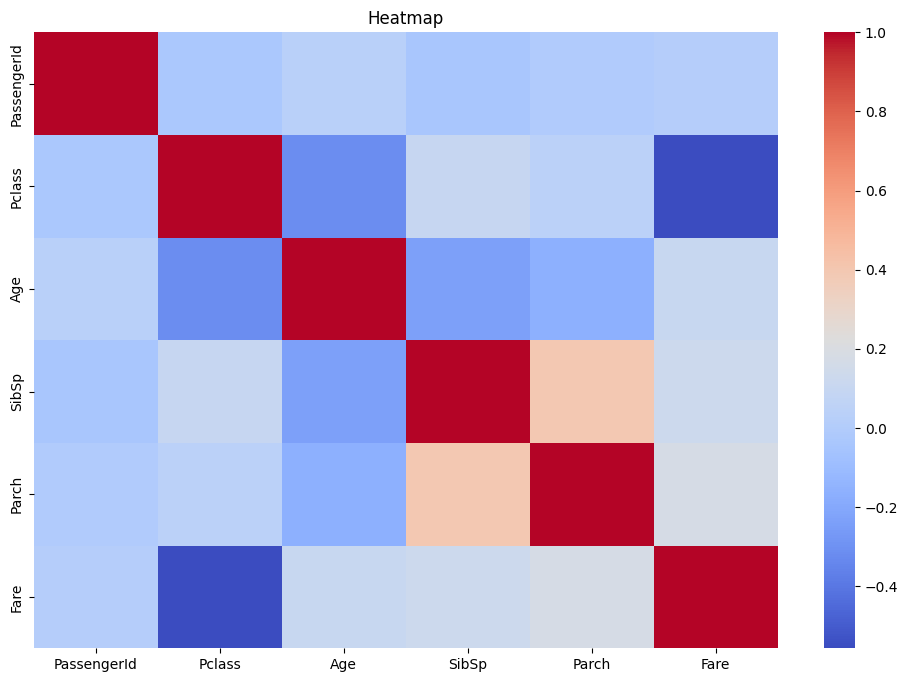

In [11]:
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix,annot=False,cmap = "coolwarm")
plt.title("Heatmap")
plt.plot()

In [12]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

numeric_X_train = X_train.select_dtypes(include=['number'])

mi_scores = mutual_info_regression(numeric_X_train, y_train, discrete_features=False)

mi_df = pd.DataFrame({
    "Features": numeric_X_train.columns,
    "MI Score": mi_scores
}).sort_values(by="MI Score", ascending=False)

low_imp = mi_df[mi_df["MI Score"] < 0.01]["Features"].tolist()

print("Low Importance Features:", low_imp)

X_train = X_train.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)


Low Importance Features: ['SibSp', 'PassengerId']


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [14]:
df = df.drop(["PassengerId", "Name", "Ticket"], axis=1)
df = pd.get_dummies(df, drop_first=True)

In [15]:
df.head()
X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
sfs_forward = SFS(RandomForestClassifier(),
                  k_features=5,
                  forward=True,
                  floating=False,
                  verbose=2,
                  scoring='accuracy',
                  cv=3)

sfs_forward = sfs_forward.fit(X_train, y_train)

print("Forward Selection Features:", X_train.columns[list(sfs_forward.k_feature_idx_)])


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.9s finished

[2025-08-21 14:29:08] Features: 1/5 -- score: 0.7893368317791252[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.5s finished

[2025-08-21 14:29:10] Features: 2/5 -- score: 0.7963514519731945[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.2s finished

[2025-08-21 14:29:12] Features: 3/5 -- score: 0.7991821201054261[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished

[2025-08-21 14:29:14] Features: 4/5 -- score: 0.8047961800754058

Forward Selection Features: Index(['Pclass', 'Age', 'SibSp', 'Sex_male', 'Embarked_S'], dtype='object')


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s finished

[2025-08-21 14:29:16] Features: 5/5 -- score: 0.818825420463544

In [17]:
sfs_backward = SFS(RandomForestClassifier(),
                   k_features=5, 
                   forward=False, 
                   floating=False, 
                   verbose=2,
                   scoring='accuracy',
                   cv=3)

sfs_backward = sfs_backward.fit(np.array(X_train), y_train)
print("Backward Selection Features:", X_train.columns[list(sfs_backward.k_feature_idx_)])

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.3s finished

[2025-08-21 14:29:19] Features: 7/5 -- score: 0.807597300523585[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.9s finished

[2025-08-21 14:29:22] Features: 6/5 -- score: 0.8103984209717643

Backward Selection Features: Index(['Pclass', 'Age', 'Sex_male', 'Embarked_Q', 'Embarked_S'], dtype='object')


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.5s finished

[2025-08-21 14:29:25] Features: 5/5 -- score: 0.8089860416740535

In [18]:
lr = LogisticRegression(max_iter=500)

efs = EFS(estimator=lr,
          min_features=1,
          max_features=4,
          scoring='accuracy',
          cv=5)

efs = efs.fit(X_train, y_train)
print("Best Accuracy Score (EFS):", efs.best_score_)
print("Best subset indices (EFS):", efs.best_idx_)
print("Best subset names (EFS):", efs.best_feature_names_)

Features: 162/162

Best Accuracy Score (EFS): 0.7991923569388358
Best subset indices (EFS): (0, 1, 5, 7)
Best subset names (EFS): ('Pclass', 'Age', 'Sex_male', 'Embarked_S')


In [19]:
model = LogisticRegression(max_iter=500)
rfe = RFE(model, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

print("RFE Selected Features:", X_train.columns[rfe.support_].tolist())
print("RFE Feature Ranking:", rfe.ranking_)

RFE Selected Features: ['Pclass', 'SibSp', 'Sex_male', 'Embarked_Q', 'Embarked_S']
RFE Feature Ranking: [1 3 1 2 4 1 1 1]
